In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# 加載訓練好的模型
model = load_model('stock_price_prediction_model_0709_lstm.h5')

# 加載待預測的數據
file_path = 'VIX0705.csv'
df = pd.read_csv(file_path, parse_dates=['DATE'])

# Select the relevant columns
selected_columns = ['OPEN', 'HIGH', 'LOW', 'CLOSE']
data = df[selected_columns].values

# 對數據進行與訓練時相同的預處理
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)



In [2]:
# 定义创建数据集的函数（与训练时相同）
def create_dataset(dataset, time_step=1):
    dataX = []
    for i in range(len(dataset) - time_step):
        dataX.append(dataset[i:(i + time_step)])
    return np.array(dataX)
# 创建数据集
time_step = 100
X_data = create_dataset(data_scaled, time_step)

# Reshape input for the model
X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], len(selected_columns))

# 进行预测
predictions = model.predict(X_data)

268/268 [==============================] - 12s 29ms/step


In [3]:
# 创建一个新的缩放器只对CLOSE进行缩放和反缩放
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit_transform(data[:, 3].reshape(-1, 1))  # 3 corresponds to 'CLOSE'

# 将预测结果进行反标准化
predictions = scaler_y.inverse_transform(predictions)

In [4]:
import csv
# 將預測結果存儲到CSV文件中
with open('prediction_0709_lstm.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Date', 'Predicted Price'])
    for i in range(len(predictions)):
        writer.writerow([df['DATE'][time_step + i].strftime('%Y-%m-%d'), predictions[i][0]])

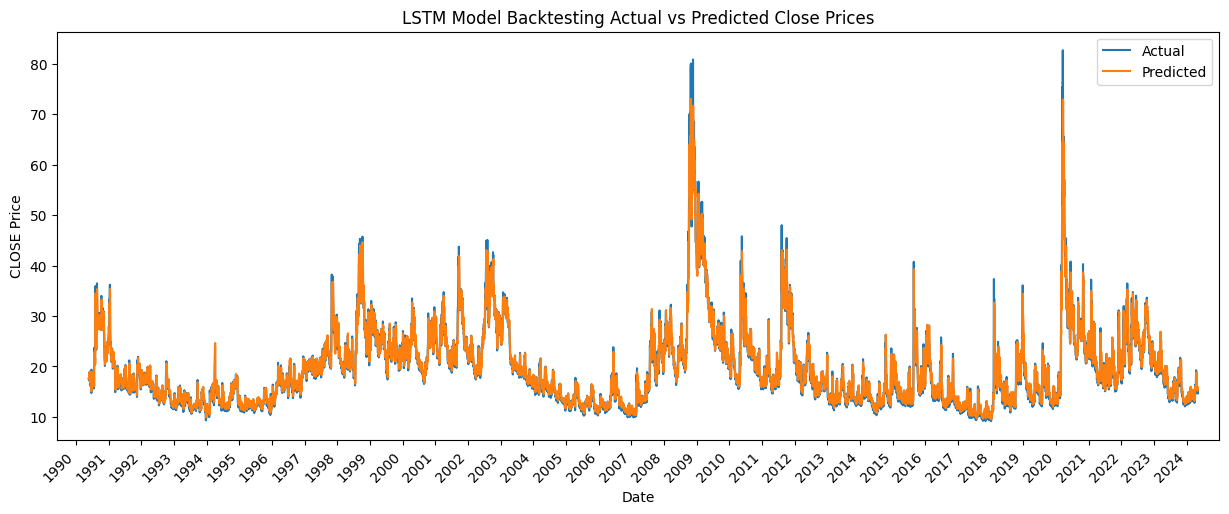

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 準備繪圖數據
actual = data[time_step:, 3]  # 移除前 time_step 個實際值

# 繪製圖表
plt.figure(figsize=(15, 6))
plt.plot(df['DATE'][time_step:], actual, label='Actual')
plt.plot(df['DATE'][time_step:], predictions, label='Predicted')

# 設置 x 軸格式顯示年份並設置範圍
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([pd.Timestamp('1989-06-01'), pd.Timestamp('2024-12-31')])

# 旋轉 x 軸標籤以提高可讀性
plt.gcf().autofmt_xdate(rotation=45)

plt.xlabel('Date')
plt.ylabel('CLOSE Price')
plt.title('LSTM Model Backtesting Actual vs Predicted Close Prices')
plt.legend()
plt.show()

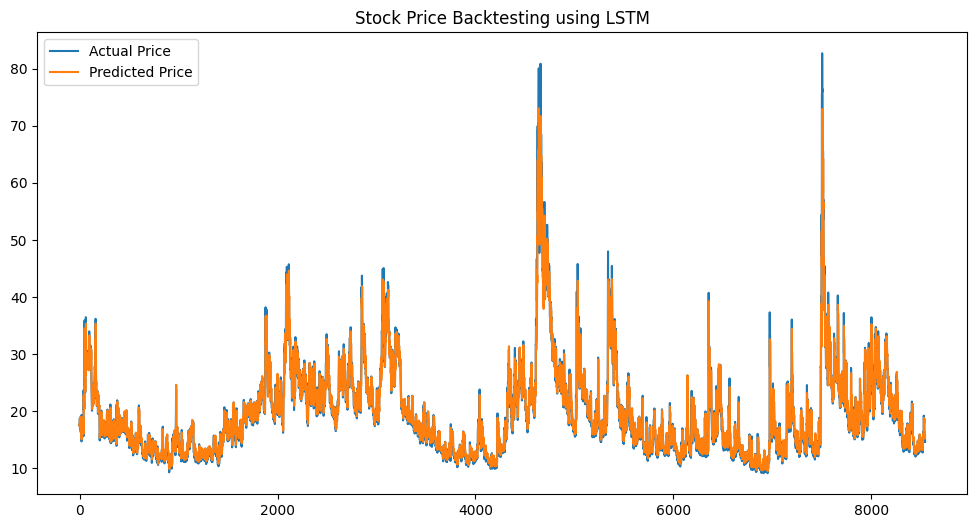

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# 获取与预测结果对应的实际值（对齐时间步长）
actual = data[time_step:, 3].reshape(-1, 1)  # 3 corresponds to 'CLOSE'

# 确保 actual 和 predictions 长度一致
actual = actual[:len(predictions)]

# 绘制预测值和实际值曲线
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Stock Price Backtesting using LSTM')
plt.legend()
plt.show()

In [7]:
# 計算指標
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predictions)
mape = np.mean(np.abs((actual - predictions.flatten()) / actual)) * 100

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MSE: 2.6006133576946686
RMSE: 1.6126417325911755
MAE: 1.0142723082781815
MAPE: 41.910979175626615
